In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [24]:
df = pd.read_csv("../../assets/survey/2025_sku_sw_survey_data.csv")

In [25]:
# 학년 -> 숫자로 변환
grade = {"1학년" : 1, "2학년" : 2, "3학년" : 3, "4학년" : 4}
df["1) 2025 기준 현재 학년"] = df["1) 2025 기준 현재 학년"].map(grade)

# 목표 직무 -> 학습에서 제외
df.drop(["2) 목표로 하는 직무 (중복선택가능)"], axis = 1, inplace=True)

# 직무 확정 시기 -> TARGET으로 사용
job_time = {"1학년" : 1, "2학년" : 2, "3학년" : 3, "4학년" : 4, "아직 미정" : 0}
df["3) 목표 직무를 확정한 시기"] = df["3) 목표 직무를 확정한 시기"].map(job_time)

# 프로젝트 경험 -> 숫자로 변환
project_cnt = {"없다" : 0, "1번" : 1, "2번" : 2, "3번 이상" : 3}
df["4) 프로젝트 경험 수"] = df["4) 프로젝트 경험 수"].map(project_cnt)

# 전공 난이도 -> 숫자로 변환
difficulty = {"매우 쉽다" : 1, "쉽다" : 2, "보통이다" : 3, "어렵다" : 4, "매우 어렵다" : 5}
df["5) 현재 느끼는 전공 난이도"] = df["5) 현재 느끼는 전공 난이도"].map(difficulty)

# 학과 커리큘럼 만족도 -> 숫자로 변환
satisfaction = {"전혀 아니다" : 1, "아니다" : 2, "보통이다" : 3, "그렇다" : 4, "매우 그렇다" : 5}
df["6) 나는 현재 학과 커리큘럼에 대해 만족한다."] = df["6) 나는 현재 학과 커리큘럼에 대해 만족한다."].map(satisfaction)

# 보유 기술 스택(다중선택) -> 각각의 칼럼으로 변경
df["스택리스트"] = df["7) 현재 보유하고 있는 기술 스택 (중복선택가능)"].fillna("")

def split_input(input): # 스택들 리스트로 저장하는 함수
    if not input:
        return []
    return [s.strip() for s in input.split(",")]

df["스택리스트"] = df["스택리스트"].apply(split_input)

skills = sorted(set(sum(df["스택리스트"], [])))

for skill in skills:
    df[f"skill_{skill}"] = df["스택리스트"].apply(lambda x : 1 if skill in x else 0) # 기술별로 칼럼 다시 생성

df.drop(["7) 현재 보유하고 있는 기술 스택 (중복선택가능)", "스택리스트"], axis=1, inplace=True) # 사용한 칼럼 삭제

# 외부 학습 의존도 -> 숫자로 변환
df["8) 외부 학습 의존도(유튜브, 인프런, 부트캠프, 스터디, 커뮤니티)"] = df["8) 외부 학습 의존도(유튜브, 인프런, 부트캠프, 스터디, 커뮤니티)"].map(satisfaction)

# TARGET 설정
targets = ["3) 목표 직무를 확정한 시기", "10) 나는 원하는 직무에서 일하기 위해 전공 강의만으로는 부족하다고 생각한다.", "11) 나는 전공 강의 이외의 추가 학습이 더 필요하다.", "13) 나는 각 직무별로 취업하기 위해 어떤 것을 공부해야 하는지 명확하게 알고 있다."]

for target in targets[1:]:
    df[target] = df[target].map(satisfaction)

drops = targets + ["타임스탬프", "12) 나는 회사에서 직무별로 요구하는 기술 스택이 상이하다고 생각한다."]
x = df.drop(drops, axis=1) # 입력
y = df[targets].values # 출력


In [26]:
# 정규화
scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42) # 일단 고정

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt

In [28]:
x_train_t = torch.tensor(x_train, dtype=torch.float)
y_train_t = torch.tensor(y_train, dtype=torch.float)

x_test_t = torch.tensor(x_test, dtype=torch.float)
y_test_t = torch.tensor(y_test, dtype=torch.float)

train_data = TensorDataset(x_train_t, y_train_t)
test_data = TensorDataset(x_test_t, y_test_t)

In [29]:
# 모델 정의
class Mymodel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(), # 신경망이 그닥 깊지 않아서 LeakyReLU 안씀
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.net(x)

In [30]:
# 하이퍼파라미터 설정
model = Mymodel(input_dim = x_train.shape[1], output_dim = y_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 최적화 함수 : Adam
criterion = nn.MSELoss() # MSE 손실함수
epochs = 150
batch_size = 16 

In [31]:
# 모델 학습
train_history, test_history = [], []

for epoch in range(epochs):

    model.train()

    indices = torch.randperm(x_train_t.size(0))
    x = x_train_t[indices]
    y = y_train_t[indices]

    x_ = x.split(batch_size, dim=0)
    y_ = y.split(batch_size, dim=0)

    train_loss = 0.0

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad() # 기울기 초기화 필수
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트

        train_loss += float(loss) # 손실 누적
    
    train_loss = train_loss / len(x_)
    train_history.append(train_loss)

    model.eval()

    # 테스트
    with torch.no_grad():
        x = x_test_t
        y = y_test_t

        x_ = x.split(batch_size, dim=0)
        y_ = y.split(batch_size, dim=0)

        test_loss = 0.0
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)
            test_loss += float(loss)
        
        test_loss = test_loss / len(x_)
        test_history.append(test_loss)

    if(epoch+1) % 10 == 0:
        print(f"[Epoch {epoch+1}] Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}")


[Epoch 10] Train loss: 8.5489, Test loss: 8.9608
[Epoch 20] Train loss: 1.5550, Test loss: 1.6222
[Epoch 30] Train loss: 0.9502, Test loss: 1.0876
[Epoch 40] Train loss: 0.7462, Test loss: 0.9316
[Epoch 50] Train loss: 0.6110, Test loss: 0.9189
[Epoch 60] Train loss: 0.5910, Test loss: 0.8531
[Epoch 70] Train loss: 0.5868, Test loss: 0.7791
[Epoch 80] Train loss: 0.5344, Test loss: 0.8086
[Epoch 90] Train loss: 0.4880, Test loss: 0.8094
[Epoch 100] Train loss: 0.3828, Test loss: 0.8105
[Epoch 110] Train loss: 0.4794, Test loss: 0.8158
[Epoch 120] Train loss: 0.3749, Test loss: 0.7890
[Epoch 130] Train loss: 0.3721, Test loss: 0.7383
[Epoch 140] Train loss: 0.4421, Test loss: 0.7528
[Epoch 150] Train loss: 0.3436, Test loss: 0.8017


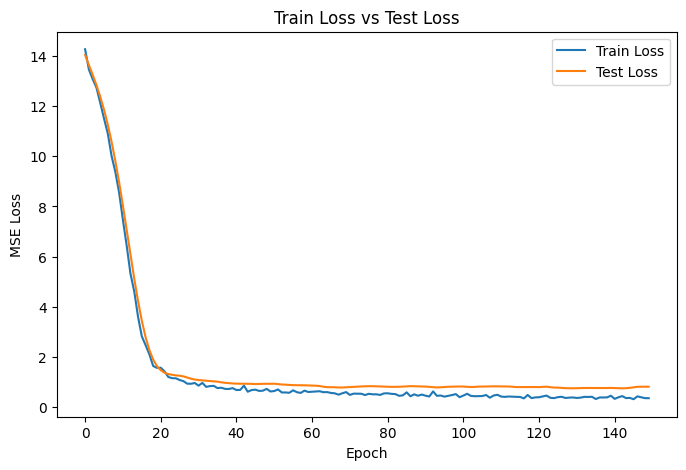

In [32]:
# 시각화

plt.figure(figsize=(8, 5))
plt.plot(train_history, label="Train Loss")
plt.plot(test_history, label="Test Loss")
plt.title("Train Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [ ]:
# 데이터 변환하는 함수
def make_feature_data(grade_, project_cnt_, difficulty_, satisfaction_, skills_, extern_, develop_level_):
    # 숫자로 변환
    grade_num = grade[grade_]
    project_num = project_cnt[project_cnt_]
    difficulty_num = difficulty[difficulty_]
    satisfaction_num = satisfaction[satisfaction_]
    extern_num = satisfaction[extern_]

    # 스택들 개별 칼럼으로 변경
    skill_col = [(1 if s in skills_ else 0) for s in skills]

    # 예시 학생 데이터 피쳐들 리스트로 변환
    features = [grade_num, project_num, difficulty_num, satisfaction_num, extern_num, develop_level_]

    # 전체 데이터 변환
    x_data = np.array(features + skill_col, dtype = np.float32)

    return x_data

# 내년 2학년이 될 학생 예시 데이터(현재 1학년 무전공)
x_data = make_feature_data(grade_ = "2학년", project_cnt_ = "없다", difficulty_ = "어렵다", satisfaction_ = "아니다", skills_ = ["Python", "Java", "C"], extern_="매우 그렇다", develop_level_=1)

x_scale = scaler.transform([x_data]) # 정규화

x_tensor = torch.tensor(x_scale, dtype = torch.float) # 텐서로 변환

model.eval()
with torch.no_grad():
    predict = model(x_tensor)
    predict_int = predict.round()

print("예측 원본 : ", predict)
print("반올림 예측 : ", predict_int)



예측 원본 :  tensor([[0.3221, 4.7673, 5.1375, 1.7798]])
반올림 예측 :  tensor([[0., 5., 5., 2.]])


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
